In [1]:
!pip install torch torchvision matplotlib scikit-image

In [2]:
import os, glob, random, shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel
from google.colab import files


In [3]:
import os, glob, random, shutil
# Upload images (PNG or JPEG)
uploaded = files.upload()

# Create train/test folders
train_dir = "/content/train_images"
test_dir  = "/content/test_images"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Collect uploaded files
all_files = list(uploaded.keys())
random.shuffle(all_files)

# 80% train / 20% test split
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
test_files  = all_files[split_idx:]

# Move files into train/test folders
for f in train_files:
    shutil.move(f"/content/{f}", os.path.join(train_dir, f))
for f in test_files:
    shutil.move(f"/content/{f}", os.path.join(test_dir, f))

print(f"✅ Training images: {len(train_files)}")
print(f"✅ Testing images: {len(test_files)}")

Saving sample1.png to sample1.png
Saving sample2.png to sample2.png
✅ Training images: 1
✅ Testing images: 1


In [4]:
class LunarDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = glob.glob(os.path.join(folder, "*.png")) + glob.glob(os.path.join(folder, "*.jpeg"))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")  # grayscale
        hr = img.resize((256, 256), Image.BICUBIC)      # High resolution (1m)
        lr = hr.resize((64, 64), Image.BICUBIC)         # Low resolution (5m)
        lr = lr.resize((256, 256), Image.BICUBIC)       # Upscale to match size

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)

        return lr, hr


In [5]:
transform = transforms.ToTensor()

train_dataset = LunarDataset(train_dir, transform=transform)
test_dataset  = LunarDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [6]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
model.eval()
os.makedirs("outputs", exist_ok=True)

# Calculate PSNR
psnr_list = []
mse_criterion = nn.MSELoss()

with torch.no_grad():
    for i, (lr, hr) in enumerate(test_loader):
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)

        # Calculate PSNR for this batch
        mse = mse_criterion(sr, hr)
        psnr = 10 * torch.log10(1 / mse)
        psnr_list.append(psnr.item())

        # Save super-resolved image
        sr_output = sr.cpu().squeeze().numpy()
        plt.imsave(f"outputs/sr_{i}.png", sr_output, cmap="gray")

# Print average PSNR
average_psnr = np.mean(psnr_list)
print(f"Average PSNR on test set: {average_psnr:.4f} dB")

Average PSNR on test set: 20.5284 dB


In [11]:
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# Final evaluation on test set
model.eval()
psnr_list = []
test_loss_list = []
mse_criterion = nn.MSELoss()

with torch.no_grad():
    for lr, hr in test_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)
        loss = criterion(sr, hr)
        test_loss_list.append(loss.item())

        mse = mse_criterion(sr, hr)
        psnr = 10 * torch.log10(1 / mse)
        psnr_list.append(psnr.item())

average_psnr = np.mean(psnr_list)
average_test_loss = np.mean(test_loss_list)

print(f"\nFinal Average PSNR on test set: {average_psnr:.4f} dB")
print(f"Final Average Loss on test set: {average_test_loss:.4f}")

Epoch [1/5], Loss: 0.0016
Epoch [2/5], Loss: 0.0014
Epoch [3/5], Loss: 0.0010
Epoch [4/5], Loss: 0.0009
Epoch [5/5], Loss: 0.0010

Final Average PSNR on test set: 31.6082 dB
Final Average Loss on test set: 0.0007


In [9]:
def generate_hazard_map(image_path, save_path):
    img = Image.open(image_path).convert("L")
    img = np.array(img, dtype=np.float32) / 255.0
    edges = sobel(img)   # slope/hazard indicator
    plt.imsave(save_path, edges, cmap="hot")

for img_path in glob.glob("outputs/sr_*.png"):
    save_path = img_path.replace("sr_", "hazard_")
    generate_hazard_map(img_path, save_path)


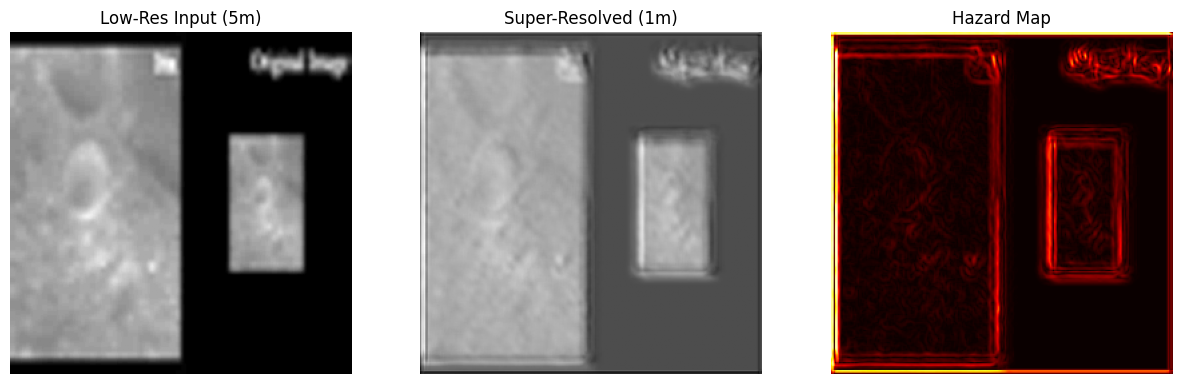

In [12]:
import matplotlib.pyplot as plt

def visualize_results(lr_img, sr_img_path, hazard_img_path):
    # Convert tensors to numpy for LR
    lr_np = lr_img.squeeze().cpu().numpy()

    # Load SR & Hazard outputs
    sr_np = np.array(Image.open(sr_img_path).convert("L"))
    haz_np = np.array(Image.open(hazard_img_path).convert("L"))

    # Plot side by side
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(lr_np, cmap="gray")
    plt.title("Low-Res Input (5m)")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(sr_np, cmap="gray")
    plt.title("Super-Resolved (1m)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(haz_np, cmap="hot")
    plt.title("Hazard Map")
    plt.axis("off")

    plt.show()

# Example: visualize first test image
test_iter = iter(test_loader)
lr, hr = next(test_iter)  # get one batch
sr_path = "outputs/sr_0.png"
haz_path = "outputs/hazard_0.png"

visualize_results(lr, sr_path, haz_path)
